# Dataanalysis

## Libraries

In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Load and Preprocess the Data

In [125]:

def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%m/%d/%Y %H:%M")
    except ValueError:
        # If that fails, try the ISO8601 format: year-month-day hour:minute:second
        try:
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M:%S")
        except ValueError:
            # Return NaT if both formats fail
            print(f"Could not parse date: {date_str}")
            return pd.NaT


# Load the CSV file into a pandas dataframe
df = pd.read_csv('ColoradoData.csv')

# Strip extra whitespace from the column names
df.columns = [col.strip() for col in df.columns]

# Strip extra whitespace from the date columns
df['Start_Date___Time'] = df['Start_Date___Time'].str.strip()
df['End_Date___Time'] = df['End_Date___Time'].str.strip()

# Now parse the datetime columns using the parse_date function
df['Start_DateTime'] = df['Start_Date___Time'].apply(parse_date)
df['End_DateTime'] = df['End_Date___Time'].apply(parse_date)

# Convert duration columns to timedelta objects
df['Total_Duration'] = pd.to_timedelta(df['Total_Duration__hh_mm_ss_'])
df['Charging_Time'] = pd.to_timedelta(df['Charging_Time__hh_mm_ss_'])

# Convert Energy consumption to a numeric type (handle errors)
df['Energy_Consumption'] = pd.to_numeric(df['Energy__kWh_'], errors='coerce')

# Remove the columns that are no longer needed
df = df.drop(columns=['Start_Date___Time', 'End_Date___Time', 'Total_Duration__hh_mm_ss_',
             'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'ObjectID', 'ObjectId2', 'Start_Time_Zone', 'End_Time_Zone', 'Port_Type'])

df.set_index('Start_DateTime', inplace=True)

# More data cleaning
# Remove rows with negative energy consumption
df = df[df['Energy_Consumption'] >= 0]

# Remove rows with missing values
df = df.dropna()

# Remove rows with zero charging time
df = df[df['Charging_Time'] > pd.Timedelta(0)]

# Remove rows with zero energy consumption
df = df[df['Energy_Consumption'] > 0]

# Remove rows with zero total duration
df = df[df['Total_Duration'] > pd.Timedelta(0)]

# Remove rows with total duration less than charging time
df = df[df['Total_Duration'] >= df['Charging_Time']]

# Verify the conversion by printing the data types
print("Optimized dataset:")
print(df.head())

Optimized dataset:
                                        Station_Name             Address  \
Start_DateTime                                                             
2018-01-01 17:49:00  BOULDER / JUNCTION ST1           2280 Junction Pl     
2018-01-02 08:52:00  BOULDER / JUNCTION ST1           2280 Junction Pl     
2018-01-02 21:11:00  BOULDER / JUNCTION ST1           2280 Junction Pl     
2018-01-03 09:19:00  BOULDER / ALPINE ST1             1275 Alpine Ave      
2018-01-03 14:13:00  BOULDER / BASELINE ST1           900 Baseline Rd      

                         City   State_Province  Zip_Postal_Code  \
Start_DateTime                                                    
2018-01-01 17:49:00  Boulder   Colorado                   80301   
2018-01-02 08:52:00  Boulder   Colorado                   80301   
2018-01-02 21:11:00  Boulder   Colorado                   80301   
2018-01-03 09:19:00  Boulder   Colorado                   80304   
2018-01-03 14:13:00  Boulder   Colorado       

## Data Cleaning and Summary Stats

In [137]:
# Check for missing values
#print("\nMissing Values in Each Column:")
#print(df.isnull().sum())

# Info about the dataset
# How many unqie charing stations are there?
print("\nNumber of unique charging stations:", df['Station_Name'].nunique())

# How many unique adresses are there?
print("\nNumber of unique addresses:", df['Address'].nunique())




Number of unique charging stations: 50

Number of unique addresses: 27


## Exploratory Data Analysis (EDA)

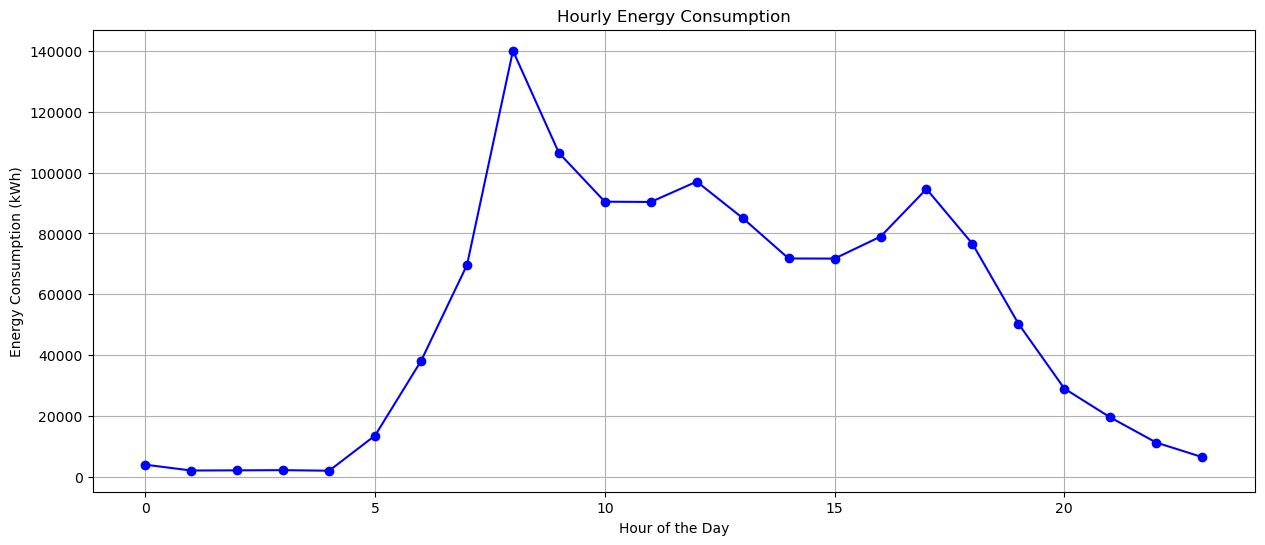

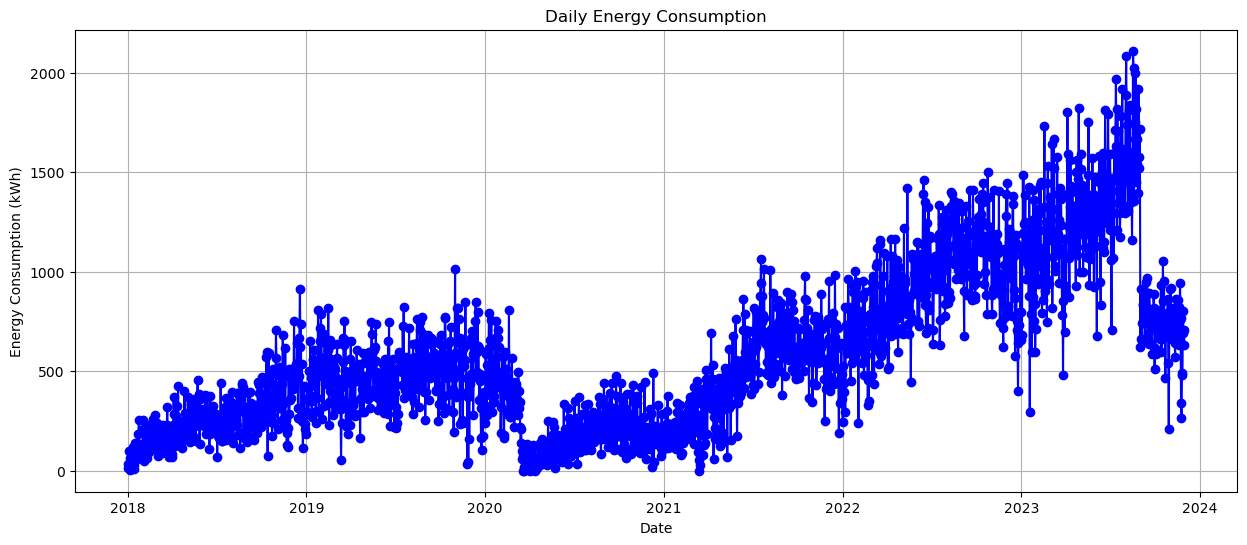

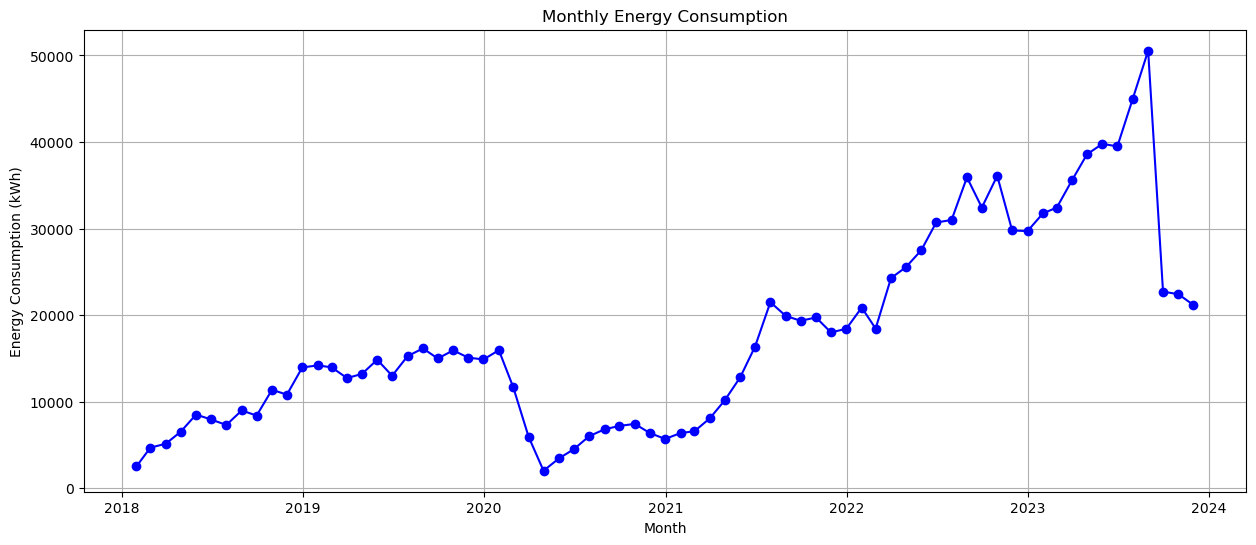

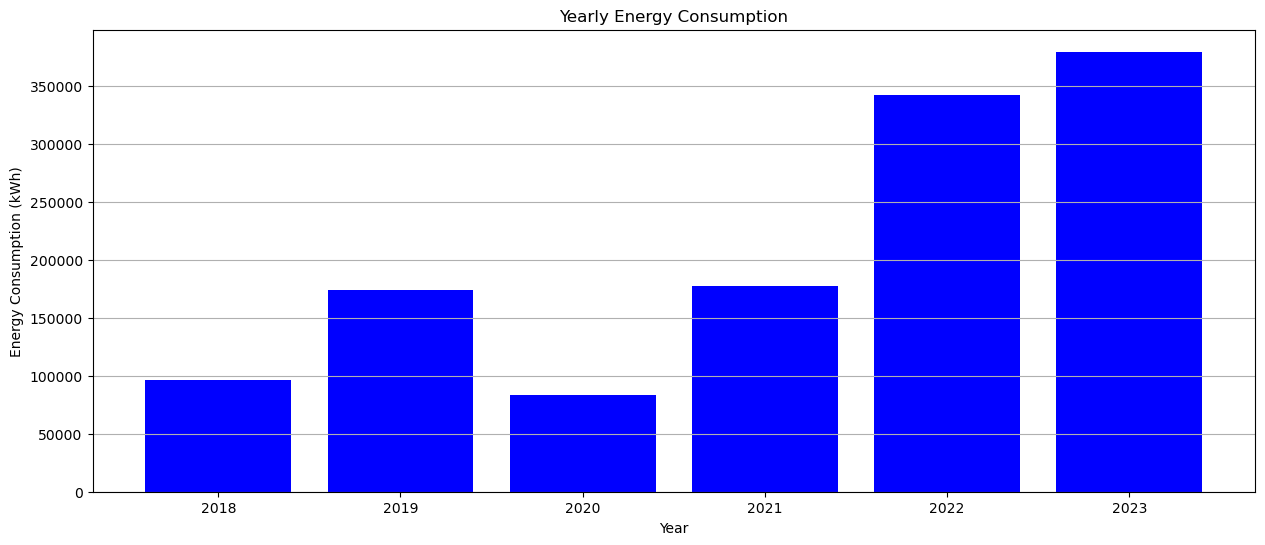

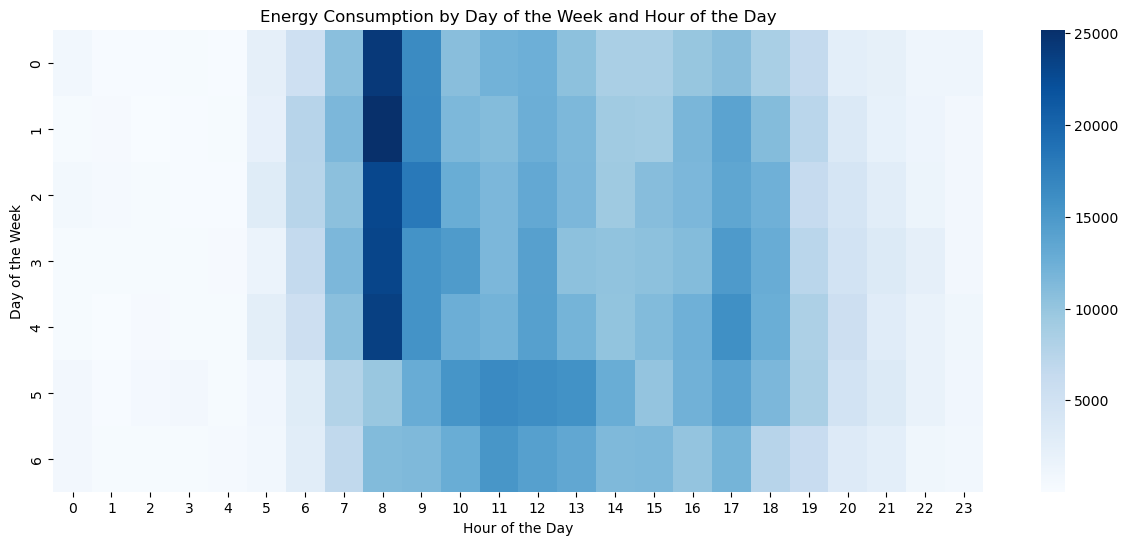

In [146]:
# Aggregate energy consumption by day, month and year
daily_energy = df['Energy_Consumption'].resample('D').sum()
monthly_energy = df['Energy_Consumption'].resample('ME').sum()
yearly_energy = df['Energy_Consumption'].resample('YE').sum()

# Plot the daily, the monthly and yearly energy consumption
def plot_daily_energy(daily_energy):
    plt.figure(figsize=(15, 6))
    plt.plot(daily_energy.index, daily_energy.values, marker='o', color='b')
    plt.title('Daily Energy Consumption')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.grid(True)
    plt.show()


def plot_monthly_energy(monthly_energy):
    plt.figure(figsize=(15, 6))
    plt.plot(monthly_energy.index, monthly_energy.values, marker='o', color='b')
    plt.title('Monthly Energy Consumption')
    plt.xlabel('Month')
    plt.ylabel('Energy Consumption (kWh)')
    plt.grid(True)
    plt.show()


def plot_yearly_energy(yearly_energy):
    plt.figure(figsize=(15, 6))
    plt.bar(yearly_energy.index.year, yearly_energy.values, color='b')
    plt.title('Yearly Energy Consumption')
    plt.xlabel('Year')
    plt.ylabel('Energy Consumption (kWh)')
    plt.grid(axis='y')
    plt.show()


# Plot agregated energy consumption by hour
def plot_hourly_energy(df):
    df['Hour'] = df.index.hour
    hourly_energy = df.groupby('Hour')['Energy_Consumption'].sum()
    plt.figure(figsize=(15, 6))
    plt.plot(hourly_energy.index, hourly_energy.values, marker='o', color='b')
    plt.title('Hourly Energy Consumption')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Energy Consumption (kWh)')
    plt.grid(True)
    plt.show()


# Heatmap of energy consumption by day of the week and hour of the day
def plot_heatmap(df):
    df['Day_of_Week'] = df.index.dayofweek
    df['Hour_of_Day'] = df.index.hour
    pivot_table = df.pivot_table(index='Day_of_Week', columns='Hour_of_Day', values='Energy_Consumption', aggfunc='sum')
    plt.figure(figsize=(15, 6))
    sns.heatmap(pivot_table, cmap='Blues')
    plt.title('Energy Consumption by Day of the Week and Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Day of the Week')
    plt.show()

# Plot hourly energy consumption 
plot_hourly_energy(df)
plot_daily_energy(daily_energy)
plot_monthly_energy(monthly_energy)
plot_yearly_energy(yearly_energy)
plot_heatmap(df)

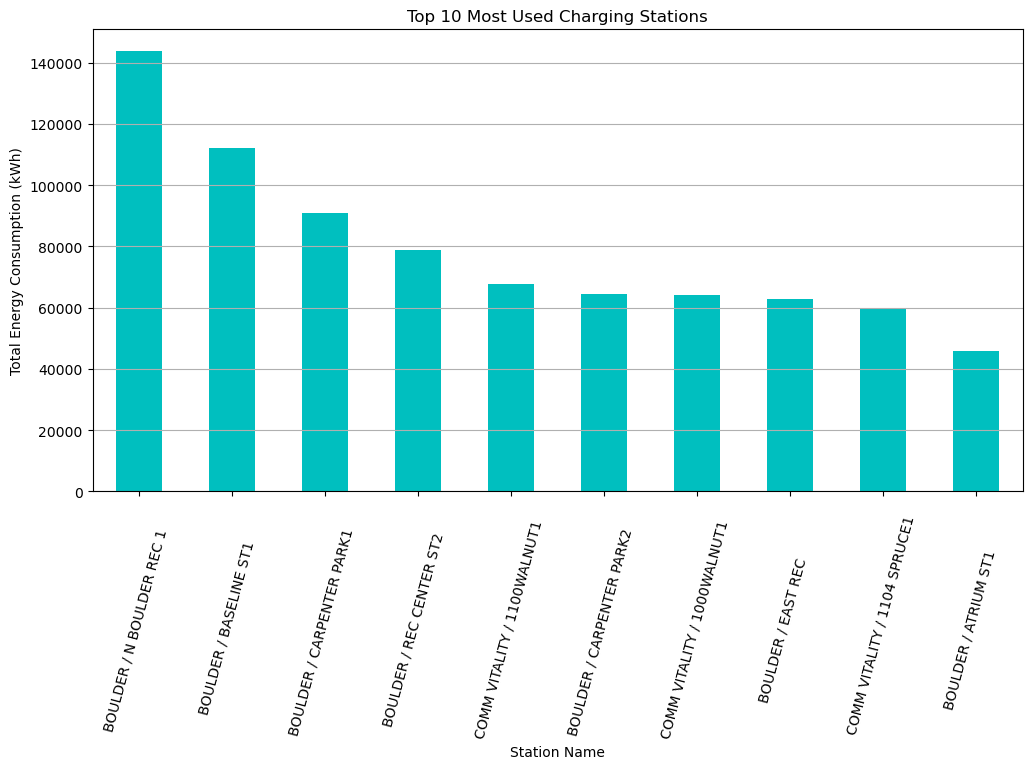

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by station and sum energy consumption
station_usage = df.groupby('Station_Name')[
    'Energy_Consumption'].sum().sort_values(ascending=False)

# Plot top 10 stations
plt.figure(figsize=(12, 6))
station_usage.head(10).plot(kind='bar', color='c')
plt.title('Top 10 Most Used Charging Stations')
plt.xlabel('Station Name')
plt.ylabel('Total Energy Consumption (kWh)')
plt.xticks(rotation=75)
plt.grid(axis='y')
plt.show()

## Station Sessions

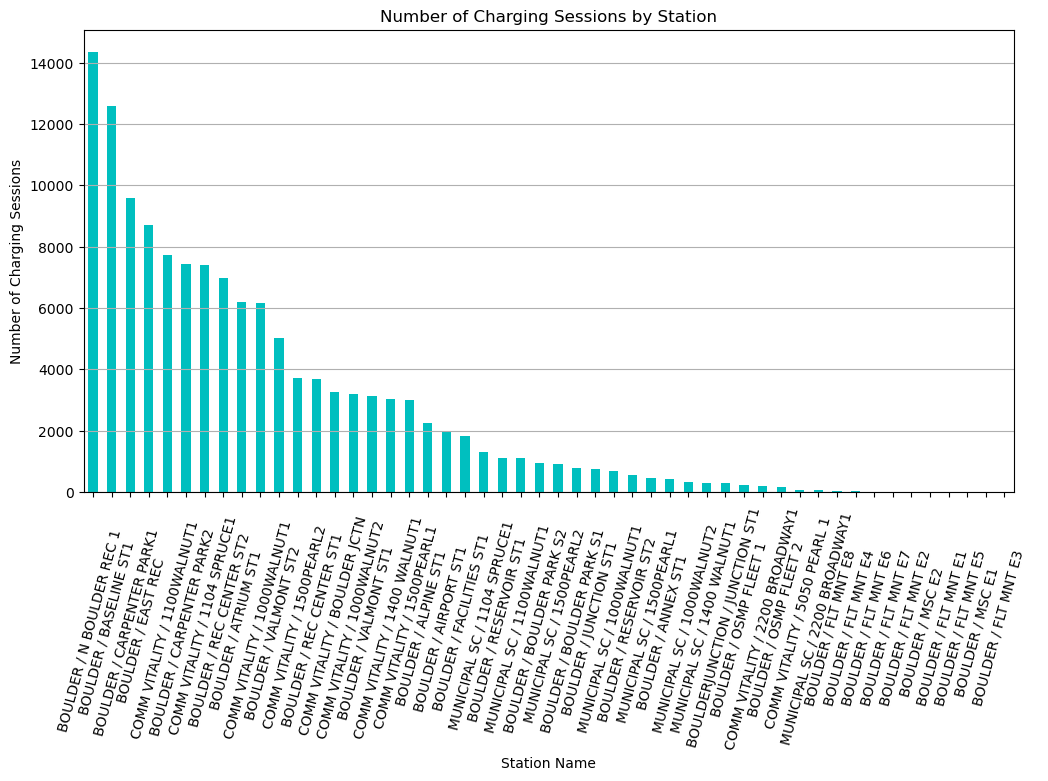

In [133]:
# Group by station and count the number of charging sessions
station_sessions = df['Station_Name'].value_counts()
def plot_station_sessions(station_sessions):
    plt.figure(figsize=(12, 6))
    station_sessions.plot(kind='bar', color='c')
    plt.title('Number of Charging Sessions by Station')
    plt.xlabel('Station Name')
    plt.ylabel('Number of Charging Sessions')
    plt.xticks(rotation=75)
    plt.grid(axis='y')
    plt.show()

plot_station_sessions(station_sessions)

## Charging Time vs Energy Consumption

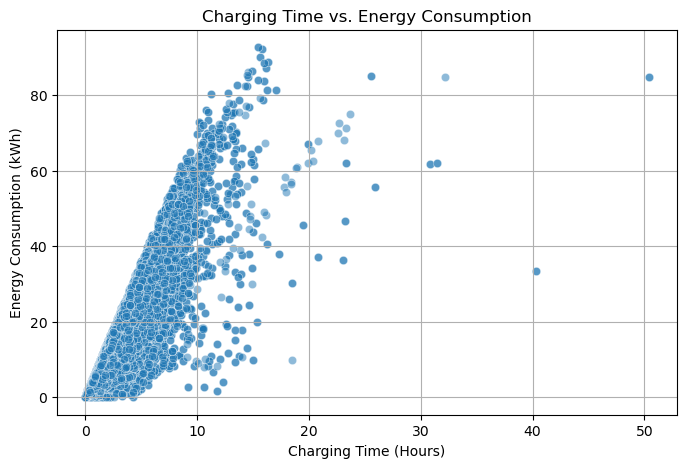

In [129]:
# Convert Charging_Time to total hours
df['Charging_Time_Hours'] = df['Charging_Time'].dt.total_seconds() / 3600

# Scatter plot of Charging Time vs. Energy Consumption
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Charging_Time_Hours'],
                y=df['Energy_Consumption'], alpha=0.5)
plt.title('Charging Time vs. Energy Consumption')
plt.xlabel('Charging Time (Hours)')
plt.ylabel('Energy Consumption (kWh)')
plt.grid(True)
plt.show()